## Private Sector Trends - Age and Location

### Use ACS data to compare private sector to Fed employees

By: Colton Lapp
colton.lapp@gsa.gov

## Import packages

In [151]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker
import geopandas as gpd

import folium 
import branca
from folium.plugins import TimeSliderChoropleth
from folium.features import GeoJsonTooltip



### Set up paths

In [152]:
# get root dir which ends in repo_name
repo_name = 'Fed_IT_Employment'
root = os.getcwd()
while os.path.basename(root) != repo_name:
    root = os.path.dirname(root)

# Get raw data directory
rdir = os.path.join( root, 'data', 'raw_data')
pdir = os.path.join(root, 'data', 'processed_data')

print(f"Base directory: {root}\nRaw data directory: {rdir}")

Base directory: /Users/coltonlapp/Dropbox/My Mac (Coltons-MacBook-Pro.local)/Desktop/Work/USDC/publicwork/Fed_IT_Employment
Raw data directory: /Users/coltonlapp/Dropbox/My Mac (Coltons-MacBook-Pro.local)/Desktop/Work/USDC/publicwork/Fed_IT_Employment/data/raw_data


## Read in ACS data
Dataset was processed in code/data_processing/get_ipums_data.ipynb

In [153]:
 # Read in processed ACS data

ACS = pd.read_csv(os.path.join(root, 'data', 'processed_data', 'IPUMS', 'IPUMS_usa_v2_extract5.csv'))

ACS.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STRATA,GQ,STATEFIP,PERNUM,...,RACE,RACED,EDUC,EDUCD,OCC2010,INDNAICS,INCTOT,DISABWRK,SPMPOV,OFFPOV
0,2005,200501,2.0,190.0,51,2005000000021,90101,1,1,1,...,2,200,6,62,5620,45211,12000.0,1.0,NaN,NaN
1,2005,200501,2.0,190.0,51,2005000000021,90101,1,1,2,...,2,200,2,21,9920,0,9999999.0,0.0,NaN,NaN
2,2005,200501,2.0,190.0,51,2005000000021,90101,1,1,3,...,2,200,2,21,9920,0,9999999.0,0.0,NaN,NaN
3,2005,200501,3.0,204.0,20,2005000000031,250001,1,1,1,...,1,100,4,40,4720,722Z,8800.0,1.0,NaN,NaN
4,2005,200501,3.0,204.0,20,2005000000031,250001,1,1,2,...,1,100,6,62,6260,23,9000.0,1.0,NaN,NaN


## Filter for only IT workers

In [154]:
# Filter for IT workers

# 1000                Computer Scientists and Systems Analysts/Network systems Analysts/Web Developers
# 1010                Computer Programmers
# 1020                Software Developers, Applications and Systems Software
# 1050                Computer Support Specialists
# 1060                Database Administrators
# 1100                Network and Computer Systems Administrators
# 1200                Actuaries
# 1220                Operations Research Analysts
# 1230                Statisticians
# 1240                Mathematical science occupations, nec

IT_codes = [1000, 1010, 1020, 1050, 1060, 1100, 1200, 1220, 1230, 1240]
IT_codes = [1000]

IT = ACS[ACS['OCC2010'].isin(IT_codes)]

# Recode missing values 
# AGE
# 999                 Missing

IT.loc[:, 'AGE'] = IT['AGE'].replace(999, None)

### Recode missing age

In [155]:
# Drop where age is missing
IT = IT.dropna(subset=['AGE'])

# Sum stats of age
IT['AGE'].describe()


count    55042.000000
mean        42.443262
std         12.941376
min         16.000000
25%         32.000000
50%         42.000000
75%         52.000000
max         95.000000
Name: AGE, dtype: float64

## Group into age groups and calculate age breakdowns

#### Weighting:
Use person weight (PERWT) to weight each ACS sample. Refer to IPUMS/ACS methodology for more info on this

In [156]:
# Create a new column for age group
IT['AGE_GROUP'] = pd.cut(IT['AGE'], bins=[0, 30, 60, 100], labels=['<30', '30-60', '>60'], right=False)

# Group by year and age group, aggregating the sum of PERWT (weights)
IT_age = IT.groupby(['YEAR', 'AGE_GROUP'], as_index=False).agg({'PERWT': 'sum'})

# Calculate weighted percentage for each age group within each year
IT_age['PERCENTAGE'] = IT_age.groupby('YEAR')['PERWT'].transform(lambda x: 100 * x / x.sum())

# Pivot the table to have age groups as columns
IT_age_pivot = IT_age.pivot(index='YEAR', columns='AGE_GROUP', values='PERCENTAGE').reset_index()

# Rename the age group columns to more descriptive labels
IT_age_pivot.columns = ['YEAR', '<30', '30-60', '>60']

# Display the resulting pivot table
IT_age_pivot

,YEAR,<30,30-60,>60
0,2005,20.643057,74.025956,5.330987
1,2010,19.265500,73.168732,7.565768
2,2015,19.564172,70.661819,9.774009
3,2020,20.636002,67.069895,12.294103


### Calculate total employment using PERWT

In [157]:
# Also calculate the total of PERWT for each year
IT_total = IT_age.groupby('YEAR', as_index=False).agg({'PERWT': 'sum'})

# rename PERWT to TOTAL_EMPLOYMENT
IT_total = IT_total.rename(columns={'PERWT': 'TOTAL_EMPLOYMENT'})

IT_total

,YEAR,TOTAL_EMPLOYMENT
0,2005,1150256
1,2010,1244302
2,2015,1640555
3,2020,2042101


### Merge total with age breakdown

In [158]:
# Merge the total PERWT with the age group pivot table
IT_age_pivot = pd.merge(IT_age_pivot, IT_total, on='YEAR')
IT_age_pivot

,YEAR,<30,30-60,>60,TOTAL_EMPLOYMENT
0,2005,20.643057,74.025956,5.330987,1150256
1,2010,19.265500,73.168732,7.565768,1244302
2,2015,19.564172,70.661819,9.774009,1640555
3,2020,20.636002,67.069895,12.294103,2042101


## Graph age distribution over time

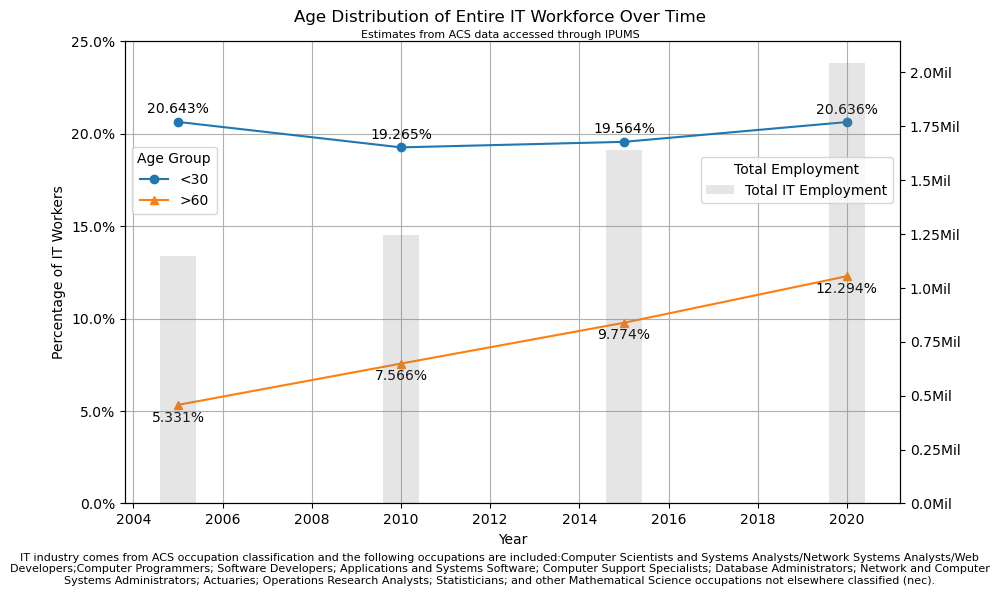

In [159]:
# Graph the percentage of IT workers in each age group over time

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the percentage of IT workers in each age group over time
# Plot the percentage of IT workers in each age group with linestyle and markers
ax.plot(IT_age_pivot['YEAR'], IT_age_pivot['<30'], label='<30', linestyle='-', marker='o')
#ax.plot(IT_age_pivot['YEAR'], IT_age_pivot['30-60'], label='30-60', linestyle='--', marker='s')
ax.plot(IT_age_pivot['YEAR'], IT_age_pivot['>60'], label='>60', linestyle='-', marker='^')


# Add percentage labels above each point for '<30'
for i, val in enumerate(IT_age_pivot['<30']):
    ax.text(IT_age_pivot['YEAR'][i], val+ .3, f'{val:.3f}%', ha='center', va='bottom', fontsize=10)

# Add percentage labels above each point for '>60'
for i, val in enumerate(IT_age_pivot['>60']):
    ax.text(IT_age_pivot['YEAR'][i], val-.3, f'{val:.3f}%', ha='center', va='top', fontsize=10)
    

ax2 = ax.twinx()
ax2.bar(IT_age_pivot['YEAR'], IT_age_pivot['TOTAL_EMPLOYMENT'], color='gray', alpha=0.2, label='Total IT Employment')

# Format the right y-axis to display values in thousands (e.g., 100K, 200K)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{round(x/1000000, 3):,}Mil'))


# Add labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Percentage of IT Workers')

# Add a grid
ax.grid(True)

# Add a y-axis percentage formatter
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Add legends for both axes
# Adjust the location of the legends to the middle
ax.legend(title='Age Group', loc='center left', bbox_to_anchor=(0, 0.7))  # Age group legend
ax2.legend(title='Total Employment', loc='center right', bbox_to_anchor=(1, 0.7))  # Total employment legend

# Subtitle saying it's based on ACS data and from IPUMS
# Adjusting subtitle to be below the title
# Add subtitle saying it's based on ACS data and from IPUMS
fig.text(0.5, 0.92, 'Age Distribution of Entire IT Workforce Over Time', ha='center', va='center', fontsize=12)
fig.text(0.5, 0.89, 'Estimates from ACS data accessed through IPUMS', ha='center', va='center', fontsize=8)

# y limit to 25
ax.set_ylim(0, 25)

# Example of adding a long caption as a footnote
fig.text(0.5, -0, 
         "IT industry comes from ACS occupation classification and the following occupations are included:"
         "Computer Scientists and Systems Analysts/Network Systems Analysts/Web Developers;"
         "Computer Programmers; Software Developers; Applications and Systems Software; Computer Support Specialists; "
         "Database Administrators; Network and Computer Systems Administrators; Actuaries; Operations Research Analysts; "
         "Statisticians; and other Mathematical Science occupations not elsewhere classified (nec).",
         ha='center', va='center', fontsize=8, wrap=True)


# Display the plot
plt.show()




# Geospatial Analysis

### Read in shapefiles and population data

In [160]:
states_shapes = gpd.read_file(os.path.join(pdir, 'states_shapefile'))
states_shapes.head()

,state,fips,geometry
0,Alabama,01,"POLYGON ((-87.359 35.001, -85.607 34.985, -85...."
1,Alaska,02,"MULTIPOLYGON (((-131.602 55.118, -131.569 55.2..."
2,Arizona,04,"POLYGON ((-109.043 37.000, -109.048 31.332, -1..."
3,Arkansas,05,"POLYGON ((-94.474 36.502, -90.153 36.496, -90...."
4,California,06,"POLYGON ((-123.233 42.006, -122.379 42.012, -1..."


In [161]:
state_population = pd.read_csv(os.path.join(pdir, 'state_population_2000_2023.csv'))
state_population.head()

,date,population,state_abbr,fips
0,2000-01-01,4452.173,AL,1
1,2001-01-01,4467.634,AL,1
2,2002-01-01,4480.089,AL,1
3,2003-01-01,4503.491,AL,1
4,2004-01-01,4530.729,AL,1


## Calculate total IT employment by state in ACS data

In [162]:
# Group by state FIPS code and calculate weighted sum of ACS data
state_IT = IT.groupby(['STATEFIP', 'YEAR'], as_index=False).agg({'PERWT': 'sum'})

# Rename PERWT to TOTAL_EMPLOYMENT
state_IT = state_IT.rename(columns={'PERWT': 'TOTAL_EMPLOYMENT'})

state_IT.head()


,STATEFIP,YEAR,TOTAL_EMPLOYMENT
0,1,2005,11136
1,1,2010,12614
2,1,2015,14830
3,1,2020,21248
4,2,2005,1921


## Merge shapefiles, population, ACS data to get per capita numbers

In [163]:
# Convert fips columns to int
state_population['fips'] = state_population['fips'].astype(int)
states_shapes['fips'] = states_shapes['fips'].astype(int)

# Merge the population data with the states GeoDataFrame
states_gdf = states_shapes.merge(state_population, on='fips')

# Convert the 'date' column to datetime
states_gdf['date'] = pd.to_datetime(states_gdf['date'])

# Extract year from date column 
states_gdf['year'] = states_gdf['date'].dt.year


# Rename date to be df specific 
states_gdf = states_gdf.rename(columns={'date': 'population_date'})
state_IT = state_IT.rename(columns={'YEAR': 'ACS_YEAR'})


# merge in the employment data
states_gdf = states_gdf.merge(state_IT, left_on=['fips', 'year'], right_on=['STATEFIP', 'ACS_YEAR'], how='inner')


states_gdf['IT_workers_per_100thousand'] = states_gdf['TOTAL_EMPLOYMENT'] / states_gdf['population']

# Show the merged GeoDataFrame
states_gdf.head()

,state,fips,geometry,population_date,population,state_abbr,year,STATEFIP,ACS_YEAR,TOTAL_EMPLOYMENT,IT_workers_per_100thousand
0,Alabama,1,"POLYGON ((-87.359 35.001, -85.607 34.985, -85....",2005-01-01,4569.805,AL,2005,1,2005,11136,2.436865
1,Alabama,1,"POLYGON ((-87.359 35.001, -85.607 34.985, -85....",2010-01-01,4785.514,AL,2010,1,2010,12614,2.635872
2,Alabama,1,"POLYGON ((-87.359 35.001, -85.607 34.985, -85....",2015-01-01,4854.803,AL,2015,1,2015,14830,3.054707
3,Alabama,1,"POLYGON ((-87.359 35.001, -85.607 34.985, -85....",2020-01-01,5031.864,AL,2020,1,2020,21248,4.222690
4,Alaska,2,"MULTIPOLYGON (((-131.602 55.118, -131.569 55.2...",2005-01-01,666.946,AK,2005,2,2005,1921,2.880293


### Data processing before mapping


In [164]:
# Check if the GeoDataFrame has a CRS
if states_gdf.crs is None:
    # Assign EPSG:4326 (WGS84) if no CRS is set
    states_gdf = states_gdf.set_crs(epsg=4326)

# Ensure the 'year' column is an integer
states_gdf['year'] = states_gdf['year'].astype(int)

# Sort the data by year
states_gdf = states_gdf.sort_values('year')

# Convert the 'year' into a datetime object representing January 1st of that year
states_gdf['date'] = pd.to_datetime(states_gdf['year'], format='%Y')

# Convert the 'date' column into Unix timestamps (seconds since epoch)
states_gdf['timestamp'] = states_gdf['date'].astype(int) // 10**9

# create year as string
states_gdf['year_str'] = states_gdf['year'].astype(str)

### Create collapsed dataframe for map showing full timeseries

In [165]:
# Group the data by 'state' and aggregate the IT worker count per year into a single string
def create_series_string(group):
    return '<br>'.join([f"Year {row['year_str']} - {round(row['IT_workers_per_100thousand'], 2)} workers" for _, row in group.iterrows()])

# Create the new condensed dataframe
condensed_df = states_gdf.groupby('state').apply(lambda group: pd.Series({
    'geometry': group['geometry'].iloc[0],  # Keep the geometry the same for each state
    'data_series': create_series_string(group)  # Create the series of year and IT workers
})).reset_index()

if condensed_df.crs is None:
    # Assign EPSG:4326 (WGS84) if no CRS is set
    condensed_df = condensed_df.set_crs(epsg=4326)

condensed_df.head()

,state,geometry,data_series
0,Alabama,"POLYGON ((-87.35930 35.00118, -85.60667 34.984...",Year 2005 - 2.44 workers<br>Year 2010 - 2.64 w...
1,Alaska,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691...",Year 2005 - 2.88 workers<br>Year 2010 - 2.85 w...
2,Arizona,"POLYGON ((-109.04250 37.00026, -109.04798 31.3...",Year 2005 - 3.84 workers<br>Year 2010 - 4.21 w...
3,Arkansas,"POLYGON ((-94.47384 36.50186, -90.15254 36.496...",Year 2005 - 1.54 workers<br>Year 2010 - 2.38 w...
4,California,"POLYGON ((-123.23326 42.00619, -122.37885 42.0...",Year 2005 - 3.88 workers<br>Year 2010 - 4.04 w...


# Make map

In [167]:
# Create a color map using branca.colormap (for smooth gradient)
max_population = states_gdf['IT_workers_per_100thousand'].max()
min_population = states_gdf['IT_workers_per_100thousand'].min()
colormap = branca.colormap.linear.YlGnBu_09.scale(min_population, max_population)  # You can adjust color palette here

# Create a dictionary to store the population data for each feature at each timestamp
styledict = {}
for i, row in states_gdf.iterrows():
    fips = row['fips']
    timestamp = row['timestamp']  # This is now based on 'year'
    population = row['IT_workers_per_100thousand']
    
    if fips not in styledict:
        styledict[fips] = {}
    
    # Use the colormap to assign colors based on population
    color = colormap(population)
    # black outline
    styledict[fips][timestamp] = {'color': color, 'opacity': 0.7, 'weight': 1, 'fillOpacity': 0.7, 'fillColor': color, 'lineColor': 'black'}


# Initialize the base map
m = folium.Map(location=[37, -102], zoom_start=5)

# Add TimeSliderChoropleth with tooltips to the map
gjson = states_gdf.set_index('fips')['geometry'].__geo_interface__  # Get the GeoJSON interface for the geometries
TimeSliderChoropleth(
    gjson,
    styledict=styledict,
    overlay=True
).add_to(m)

for idx, row in condensed_df.iterrows():
    # Get the centroid of each state's geometry (to place the label)
    centroid = row['geometry'].centroid
    folium.map.Marker(
        [centroid.y, centroid.x],  # Latitude and longitude of the centroid
        icon=folium.DivIcon(
            html=f"""
            <div style="font-size: 10px; color: grey; font-weight: bold;
                        text-shadow: -1px -1px 0 #fff, 1px -1px 0 #fff, -1px 1px 0 #fff, 1px 1px 0 #fff;">
                {row['state']}
            </div>
            """
        )
    ).add_to(m)

# Add hover popup with state name and the entire IT worker count series
folium.GeoJson(
    condensed_df[['geometry', 'state', 'data_series']],
    name='IT Workers',
    style_function=lambda x: {'fillColor': 'transparent', 'color': 'transparent'},  # Keep geometry transparent
    popup=folium.GeoJsonPopup(
        fields=['state', 'data_series'],  # Fields to include in the popup
        aliases=['State:', 'IT Workers Per 100K Residents:'],  # Labels to display in the popup
        localize=True,
        max_width=300,
        parse_html=True
    )
).add_to(m)
# Add a colormap legend to the map
colormap.caption = 'IT Managers Population Per Hundred Thousand People'
colormap.add_to(m)

# Add the title and subtitle to the map
title_html = '''
     <h3 align="center" style="font-size:20px"><b>IT Workers Per Capita Over Time - Private and Public Workers</b></h3>
     <h4 align="center" style="font-size:15px"><i>Data source: American Community Survey (ACS) Accessed through IPUMS API</i></h4>
     '''
m.get_root().html.add_child(folium.Element(title_html))

# save output to root/output/IT_workers_per_capita.html
m.save(os.path.join(root, 'output', 'ACS_IT_workers_per_capita.html'))

# Display map (in Jupyter Notebook)
m